In [2]:
%matplotlib notebook

import numpy as np
import seaborn as sns
import pandas as pd

sns.set_context("paper")

# Table of Contents
* [Intro](#Intro)
* [Data Loading](#Data-Loading)
* [Function Application](#Function-Application)
* [Group-By and Aggregation](#Group-By-and-Aggregation)
	* [Plotting](#Plotting)
	* [Multi-Index](#Multi-Index)
* [Pivoting, Stacking and Melting](#Pivoting,-Stacking-and-Melting)
	* [Facet Grid](#Facet-Grid)
* [Filling time ranges](#Filling-time-ranges)
* [Notes](#Notes)


# Intro

In this notebook, I'm going to demonstrate with practical examples various concepts and methods related to Pandas and Seaborn. I will rely on the data format I used for my [Facebook Conversation Analyzer project](https://github.com/5agado/conversation-analyzer). For seemingly obvious reasons I didn't use a personal conversation but automatically generated a fake and nonsensical one. Projecting or imagining some conversation relevant to you will most likely help you to better understand and memorize the content of this notebook, even greater if you can play around with your actual data.

The main topic is data manipulation with Pandas, for example function application, groupby, aggregation and multi-indexes. All along I'll mention handy tricks that you can use for various tasks and demonstrate how we can plot results in different ways using [Seaborn](http://seaborn.pydata.org/index.html) (based on matplotlib). Given the data format, special focus is put on time-series data manipulation.

# Data Loading

Assuming you already have your data in a valid csv format, loading it in a Pandas dataframe is as easy as calling [*pd.read_csv*](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html).

We additionally care about the **automatic datetime parsing** for certain columns. With the *parse_dates* argument, we tell Pandas which date should be forced to datetime format. You can also pass a custom parser, something like: *date_parser = lambda x : pd.datetime.strptime(x, '%H:%M:%S'))*

In [3]:
# Load conversation messages
msgs = pd.read_csv('test_conv.csv', parse_dates=['datetime'])
# Display first 5 entries of our dataframe
msgs.head()

,datetime,sender,text
0,2016-01-11 00:16:51,Donnie,I... remember.
1,2016-01-11 19:06:48,Donnie,I'm sure you would.
2,2016-01-12 18:10:15,Donnie,Where is my mother! How oddly thou repliest! Y...
3,2016-01-13 21:45:27,Donnie,"I'm at Space Station Five, darling. How are you?"
4,2016-01-14 15:44:06,Frank,You were never invited to my house.


In [4]:
# Double check of types
msgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
datetime    1000 non-null datetime64[ns]
sender      1000 non-null object
text        1000 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 23.5+ KB


# Function Application

Function application allows you to map a function to elements (cells, rows, columns) of your dataframe (or series) in a computationally efficient way.  

We will try out function application in the preprocessing step for the textual component of our messages.
We are going to use a dummy method for tokenization (transform text to list of words) and then compute some stats on the spot (e.g. text length, word count).

When using [*apply*](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) on a dataframe, always double check on the *axis* parameter, it's easy to forget or confuse it, causing annoying errors. 0 (default) is for applying the function to each column, 1 to each row.

In [5]:
# Most simple and dummy method possible for tokenizing your text
def get_words(text):
    return text.strip().split()

In [6]:
# Our function to apply. When applied to a dataframe this will get a row as input
def extract_text_basic_stats(row):
    # tokenize our message text
    words = get_words(row['text'])
    # Compute message stats and add entries to the row
    # For demonstration purposes, but otherwise clearly inefficient way to do it
    row['text_len'] = len(row['text'])
    row['num_tokens'] = len(words)
    row['num_types'] = len(set(words))
    return row

# We apply row wise, so axis = 1
msgs_stats = msgs.apply(extract_text_basic_stats, axis=1)
msgs_stats.head()

,datetime,sender,text,text_len,num_tokens,num_types
0,2016-01-11 00:16:51,Donnie,I... remember.,14,2,2
1,2016-01-11 19:06:48,Donnie,I'm sure you would.,19,4,4
2,2016-01-12 18:10:15,Donnie,Where is my mother! How oddly thou repliest! Y...,100,18,16
3,2016-01-13 21:45:27,Donnie,"I'm at Space Station Five, darling. How are you?",48,9,9
4,2016-01-14 15:44:06,Frank,You were never invited to my house.,35,7,7


With previous approach (i.e. applying function on dataframe) we can rely on the entire information present in a row. For this specific case is a bit of an overhead, mostly cause we are using only the *text* field. 
We can then instead simply **apply our function directly to our target column**, and pack the result values in a new dataframe that will be joined with our original one.

In [7]:
# Our function to apply. When applied to a series/column this will get a cell value as input
def extract_text_basic_stats(text):
    words = get_words(text)
    # Return results as tuples. You can also return a dictionary for automatic insertion in a dataframe
    return len(text), len(words), len(set(words))

# Apply function to text column
stats = msgs['text'].apply(extract_text_basic_stats).values
# Pack results in a new dataframe and join it with our original one
msgs_stats = pd.DataFrame(list(stats), columns=['text_len', 'num_tokens', 'num_types'])
msgs_stats = msgs.join(msgs_stats)
msgs_stats.head()

,datetime,sender,text,text_len,num_tokens,num_types
0,2016-01-11 00:16:51,Donnie,I... remember.,14,2,2
1,2016-01-11 19:06:48,Donnie,I'm sure you would.,19,4,4
2,2016-01-12 18:10:15,Donnie,Where is my mother! How oddly thou repliest! Y...,100,18,16
3,2016-01-13 21:45:27,Donnie,"I'm at Space Station Five, darling. How are you?",48,9,9
4,2016-01-14 15:44:06,Frank,You were never invited to my house.,35,7,7


# Group-By and Aggregation

Stats by day can be too granular for our interests, while seeing the trend per months can provide a better and clearer understanding on what's going on. Seems the right time to rely on [group-by and aggregation](http://pandas.pydata.org/pandas-docs/stable/groupby.html).

*groupby* groups your entries by common values, where the values come from field (or set of) you specify. For example, I might group my messages by sender and month, and for each combination of them will obtain a list of associated and recorded values. **Aggregation** is about telling what do do with such list: sum, average, min, max, standard deviation are just some common examples. In the case of more complex types like list or string, you might instead perform concatenation or set operations.

When dealing with time-series data is good to consider also the [resample](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) method.

In [8]:
# Create new feature by extracting the month from the date
msgs_stats['month'] = msgs_stats['datetime'].dt.month
# Group by month and sender and aggregate by sum
grouped_msgs = msgs_stats.groupby(['sender','month']).sum()
grouped_msgs.head()

text_len  num_tokens  num_types
sender month                                 
Donnie 1          1311         251        239
       2          1487         280        265
       3          2236         436        417
       4          2379         449        430
       5          1369         260        248

*.dt* is a quick and nice way to access just the part of your datetime object you interested in, something like *.dt.month*, *.dt.year*, *.dt.hour*. Notice you could directly group by month by passing *msgs_stats['datetime'].dt.month* to the groupby list, thus avoiding the need of creating a new month column beforehand.

While the previous is a simple example of aggregation, we can also get further and **derive several stats in one go**, by specifying which function to apply for each new column. Again, you could also rely on lambda or previously defines functions, and pass them to the *agg* method.

In [9]:
# Create destination column for new stats
msgs_stats['max_tokens'] = msgs_stats['num_tokens']
msgs_stats['avg_tokens'] = msgs_stats['num_tokens']
# Groupby and apply specific aggregation to each column we are interested in
grouped_msgs = msgs_stats.groupby(['sender','month']).agg({'max_tokens' : np.max, 'avg_tokens' : np.mean,
                                                          'num_tokens': sum, 'num_types' : sum})
grouped_msgs.head()

avg_tokens  num_types  max_tokens  num_tokens
sender month                                               
Donnie 1        7.606061        239          20         251
       2        8.750000        265          20         280
       3        9.478261        417          24         436
       4        8.803922        430          20         449
       5        7.222222        248          19         260

## Plotting

Let's look into some basic plotting with the current data. A pointplot seems a reasonable representation, and we just have to pass our data to the corresponding method. We can pass directly the x and y values, or pass the entire dataframe as *data* and specify column names associated to x and y. The *hue* parameter allows to specify the column which values will be plotted separately, with different colors. As an example see the representation of sender-specific stats in the following plot.

Notice that I often call *reset_index()* before passing the data to the plot function, cause in such a way I can access also index columns by names. I'm currently still not aware of any way to use index names directly.

Is good to also consider **alternative options for plotting**, like calling the *plot* function directly provided by Pandas. Or accessing Matplotlibs plot methods via *sns.plt.*

<IPython.core.display.Javascript object>


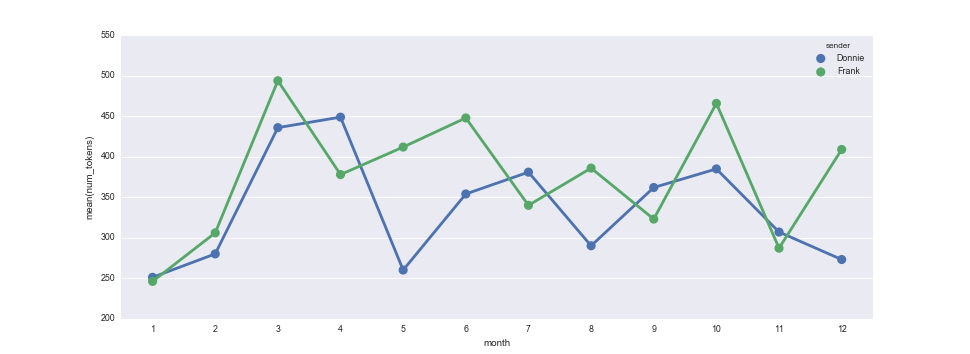

In [10]:
sns.pointplot(x='month', y='num_tokens', data=grouped_msgs.reset_index(), hue='sender')
sns.plt.show()

## Multi-Index

When using *groupby* the *as_index* parameter specifies if the columns used for grouping should be used as indexes of the resulting dataframe, if set to *False* such columns will otherwise end up to be part of the other set of columns. So if you group by multiple values, and keep them as index, you will end up with a multi-index dataframe, like the one in our previous example (sender and month).   
Understanding and being able to manage [multi-indexes](http://pandas.pydata.org/pandas-docs/stable/advanced.html) is a fundamental requirement when working with more complex dataset, so I will now quickly play with them for a multiplot scenario.

Now that you have your resampled data, what do you want to plot?
We can reuse this dataframe for different possible plots/queries. We might be interested in the statistics for a specific sender, specific month, combination of the two, or just the overall values.

With single index we can access my sender with *.loc['Donnie']*, now with a multi-index we use the *.xs* method instead.

<IPython.core.display.Javascript object>


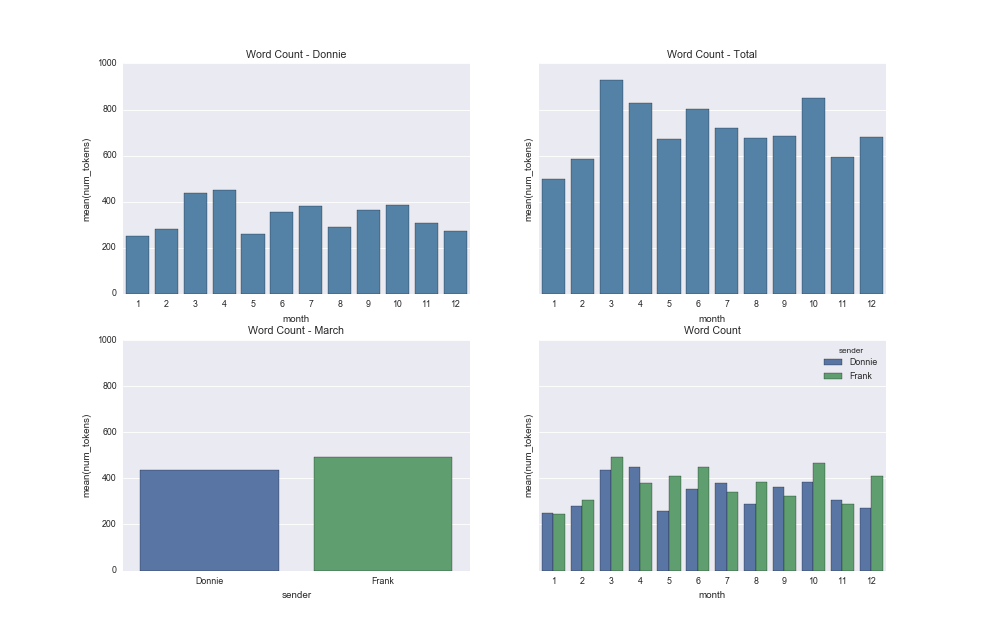

In [11]:
# Create figure with two plots
fig, axes = sns.plt.subplots(2, 2, sharey=True)

# Get messages for a specific sender and plot values
msgs_sender = grouped_msgs.xs('Donnie', level='sender')
axes[0,0].set_title('Word Count - Donnie')
sns.barplot(x='month', y='num_tokens', data=msgs_sender.reset_index(), ax=axes[0,0], color="steelblue")

#or we can plot the total, reusing  groupby, on the index this time, and summing the results
msgs_total = grouped_msgs.groupby(level='month').sum()
axes[0,1].set_title('Word Count - Total')
sns.barplot(x='month', y='num_tokens', data=msgs_total.reset_index(), ax=axes[0,1], color="steelblue")

#or check for a single month
msgs_month = grouped_msgs.xs(3, level='month')
axes[1,0].set_title('Word Count - March')
sns.barplot(x='sender', y='num_tokens', data=msgs_month.reset_index(), ax=axes[1,0])

#or finally plot all in one, withouth additional selection
axes[1,1].set_title('Word Count')
sns.barplot(x='month', y='num_tokens', hue='sender', data=grouped_msgs.reset_index(), ax=axes[1,1])

sns.plt.show()

# Pivoting, Stacking and Melting

What is all this about? It's about swirling your dataframe data around in an ordered way, for friends: [reshaping](http://pandas.pydata.org/pandas-docs/stable/reshaping.html). 

With **pivot** you directly control which columns end up to form your index, which your columns, and which your values.

**Stacking** operates a pivoting of columns (different columns become a single new attribute, duplicating the number of samples for each column label).  
In the following lines we stack our messages statistics into a single *stats* column, that specifies which statistics we are considering, and has the associated value in the *val* column.

In [12]:
# First prepare data by extracting year info and group-by sum
msgs_stats['year'] = msgs_stats['datetime'].dt.year
yearly_msgs = msgs_stats.groupby(['sender','month','year']).sum()
yearly_msgs = yearly_msgs.drop('text_len', axis=1)
yearly_msgs.head()

num_tokens  num_types  max_tokens  avg_tokens
sender month year                                               
Donnie 1     2016         124        117         124         124
             2017         127        122         127         127
       2     2016         150        140         150         150
             2017         130        125         130         130
       3     2016         196        187         196         196

In [13]:
# Stack our data and rename columns
yearly_msgs = yearly_msgs.stack().reset_index()
yearly_msgs.columns.values[3] = 'stat'
yearly_msgs.columns.values[4] = 'val'
yearly_msgs.head()

,sender,month,year,stat,val
0,Donnie,1,2016,num_tokens,124
1,Donnie,1,2016,num_types,117
2,Donnie,1,2016,max_tokens,124
3,Donnie,1,2016,avg_tokens,124
4,Donnie,1,2017,num_tokens,127


## Facet Grid

This format doesn't follow the [tidy data guidelines](http://vita.had.co.nz/papers/tidy-data.pdf), but can be useful for quick playing around and plotting, especially when using Seaborn [FacetGrid](http://seaborn.pydata.org/generated/seaborn.FacetGrid.html). We compose our plot specifying how subplots are built in terms of rows and columns, for then applying to each a basic plotting function.

In the following example each column is a year, and different rows are different statistics about our messages. Each plot will then show the values along months, for each sender. Even if this explanation sounds convoluted, the actual plot is really intuitive and helpful when visualizing such kind of data. 

The **sharing of axis** (keep the same scale for the plots) is also an important part of the grid, that can help visualize how your values vary among different plots. At the same time some sharing might just be counterproductive, for example when comparing values with a big scale or range difference. We have one of such cases when comparing *text_len* with the other stats.

<IPython.core.display.Javascript object>


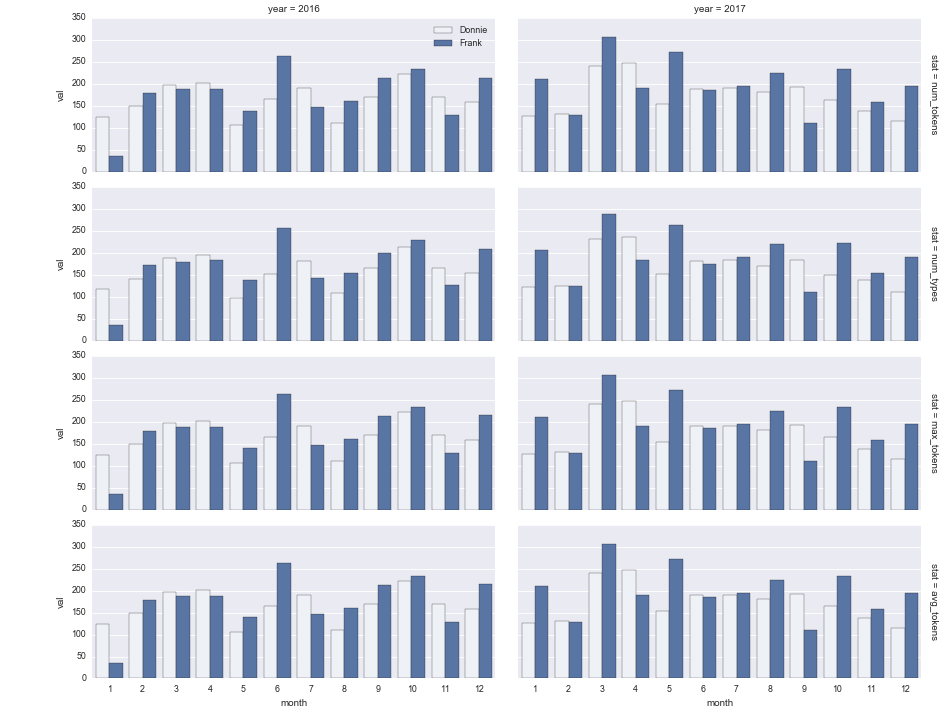

In [14]:
# Create grid specifying to use years for columns and stats for rows
grid = sns.FacetGrid(yearly_msgs, col='year', row='stat', margin_titles=True, sharey=True, legend_out=True)
# Map to each grid sub-plot a barplot
grid.map(sns.barplot, 'month', 'val', 'sender')
grid.axes[0][0].legend()
sns.plt.show()

# Filling time ranges

If you look closely at our messages occurrences, you can see that not all days are covered. If you index by date you will end up with something like the dataframe showed next.

During the analysis part as operated until now this content might be okay and exactly what we need, but when plotting, missing entries are just misleading, showing a consecutive change for non-consecutive dates. What we might do is **fill our time index with all possible dates**, and associate with the new entry the most appropriate value. 
Missing-value filling deserves an article itself; however, for our dataset, the most appropriate option is to simply assign to each nonpresent entry a value of 0, correctly representing that for such a day no messages have been sent.

To build our complete list of dates we can rely on Pandas *date_range* method, then [reindex](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reindex.html) the dataframe and insert our new values. In the final plot, you will notice that all dates are now present and with associated value of 0.

In [15]:
# Drop unused columns
msgs_stats.drop(['year', 'month'], axis=1, inplace=True)
# Extract date as new column
msgs_stats['date'] = msgs_stats['datetime'].dt.date
# Group-by date and sum, selecting just a subset of samples
fill_time_msgs = msgs_stats.groupby(['date']).sum().iloc[:20,:]
# Show example of discontinuous entries
fill_time_msgs[10:]

,text_len,num_tokens,num_types,max_tokens,avg_tokens
date,,,,,
2016-01-23,12,2,2,2,2
2016-01-25,21,4,4,4,4
2016-01-26,67,13,11,13,13
2016-01-27,44,10,10,10,10
2016-01-29,17,4,4,4,4
2016-02-02,22,4,4,4,4
2016-02-04,28,6,6,6,6
2016-02-06,56,8,8,8,8
2016-02-07,95,19,19,19,19


In [17]:
# Generate our dates range using dates of first and last message
start_date = fill_time_msgs.index.values[0]
end_date = fill_time_msgs.index.values[-1]
dates = pd.date_range(start=start_date, end=end_date)
dates = [d.date() for d in dates]
print(dates)

[datetime.date(2016, 1, 11), datetime.date(2016, 1, 12), datetime.date(2016, 1, 13), datetime.date(2016, 1, 14), datetime.date(2016, 1, 15), datetime.date(2016, 1, 16), datetime.date(2016, 1, 17), datetime.date(2016, 1, 18), datetime.date(2016, 1, 19), datetime.date(2016, 1, 20), datetime.date(2016, 1, 21), datetime.date(2016, 1, 22), datetime.date(2016, 1, 23), datetime.date(2016, 1, 24), datetime.date(2016, 1, 25), datetime.date(2016, 1, 26), datetime.date(2016, 1, 27), datetime.date(2016, 1, 28), datetime.date(2016, 1, 29), datetime.date(2016, 1, 30), datetime.date(2016, 1, 31), datetime.date(2016, 2, 1), datetime.date(2016, 2, 2), datetime.date(2016, 2, 3), datetime.date(2016, 2, 4), datetime.date(2016, 2, 5), datetime.date(2016, 2, 6), datetime.date(2016, 2, 7), datetime.date(2016, 2, 8)]


<IPython.core.display.Javascript object>


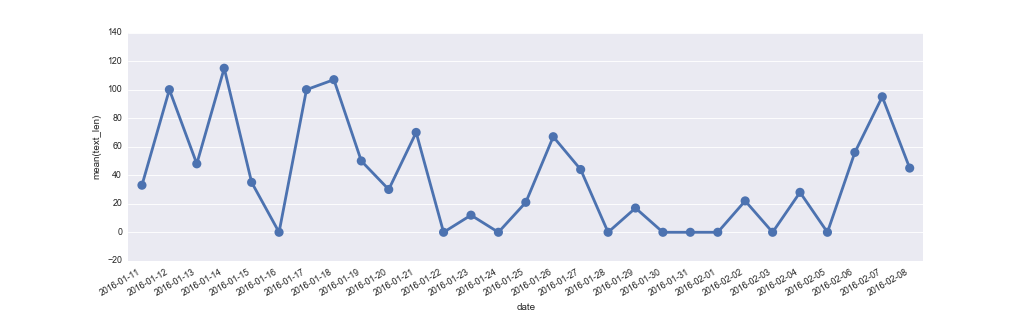

In [18]:
# Reindex using dates, specify as filling value 0, as previously discussed
fill_time_msgs = fill_time_msgs.reindex(dates, fill_value=0)
fill_time_msgs.index.name = 'date'
# Plot data
sns.pointplot(x='date', y='text_len', data=fill_time_msgs.reset_index())
sns.plt.gcf().autofmt_xdate()
sns.plt.show()

# Notes

I'm using this notebook as a personal "wiki" and practice field, as a mean to clarify my understanding and knowledge of the topic. I chose to share cause you know, you tend to do better when you go public, but also I'm hoping for possible feedback, comments or critiques. In the future I might explore other important operations here missing (take joining and merging for example), or go into more specific details on things already explored, also based on eventual feedback.

**Pandas and Seaborn are pretty cool**, both for personal or work related projects, but I'm also open to possible new alternatives or additions to use for the task of data analysis and visualization, so feel free to give me your feedback on this too.